# TP 1: Neurosciences et inférence bayésienne

### 18 février 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

#### Fonctions générales

In [1]:
import fnmatch
import functools
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from Romberg_mod import romberg_mod
from scipy.special import gamma
from uncertainties import (
    ufloat,  # Uncertainties: a Python package for calculations with uncertainties, Eric O. LEBIGOT, http://pythonhosted.org/uncertainties/
)

sns.set_theme(style="ticks", palette="deep")

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Liste les noms de fichier d'un dossier
def listNameOfFiles(directory: str, extension="txt"):
    found_files = []
    for file in os.listdir(directory):
        if fnmatch.fnmatch(file, f"*.{extension}"):
            found_files.append(file)
    return found_files


# Lis et crée une matrice numpy à partir de chemin d'un fichier texte
def readTXT(path: str):
    fich = open(path, "r")
    fich_str = list(fich)
    fich.close()
    x = []
    for i in fich_str:
        elem_str = i.replace("\n", "")
        x.append(float(elem_str))
    return np.array(x)


# Intégration par méthode de Simpson 'nested' et récursive dans le cas d'instabilité
def nested_simpson(f: callable, a: float, b: float, N: int):
    if N < 3:
        return "La valeur minimale est 3, car la méthode de simpson nécessite 3 points par approximation"
    N0 = N
    h0 = (b - a) / N
    even = np.linspace(2, N - 2, int((N - 2) / 2), dtype=int)
    odd = np.linspace(1, N - 1, int((N - 1) / 2), dtype=int)
    S0 = (f(a) + f(b) + 2 * np.sum(list(map(f, a + even * h0)))) / 3
    T0 = 2 / 3 * np.sum(list(map(f, a + odd * h0)))
    res0 = h0 * (S0 + 2 * T0)
    err = np.inf
    lres = [res0]
    lerr = [err]
    while err > 1e-16:
        N = N * 2
        hi = (b - a) / N
        Si = S0 + T0
        Ti = 2 / 3 * np.sum(list(map(f, a + odd * hi)))
        res = hi * (Si + 2 * Ti)
        err = (abs((res - res0)) / 3) / res
        if err > lerr[-1]:
            tes = nested_simpson(f, a, b, N0 + 1)
            if tes:
                return tes

        lres.append(res)
        lerr.append(err)
        S0 = Si
        T0 = Ti
        res0 = res
    return lres, lerr, N0, a, b


# Définition de pi(lambda) pour une loi Gamma
def pi_lambda(Lambda: float, alpha: int, beta: float):
    return (
        1
        / gamma(alpha)
        * Lambda ** (alpha - 1)
        * np.exp(-beta * Lambda)
        * beta ** (alpha)
    )


# Définition de la loi de Poisson
def poisson(x, Lambda):
    return Lambda * np.exp(-Lambda * x)


# Définition ddu théorème de Bayes
def bayes(Lambda, data):
    x = np.sort(np.ediff1d(data))
    return pi_lambda(Lambda, 2, 0.25) * np.prod(poisson(x, Lambda))


# Définition de la loi a posteriori
def posteriori(Lambda, data):
    return Lambda * bayes(Lambda, data)

# Montre les résultats des itérations de la méthode de Romberg
def show_Romberg(test):
    interval = test[1]
    resmat = test[2]
    err = test[4]
    print("Méthode de Romberg:\n")
    print("De lambda = ", interval)
    print("")
    print("%6s %9s " % ("N", "h"))
    for i in range(1, len(resmat) - 1):
        print("%6d %9f" % (2**i, (interval[1] - interval[0]) / (2.0**i)), end=" ")

        print("Résultat = %.15E" % (resmat[i][-1]), end=" ")
        print("Erreur = %.15E" % err[i], end=" ")
        print("Erreur relative = %.15E" % (err[i] / resmat[i][-1]), end=" ")
        print("")
    print("")
    print("Le résultat final est", "%.15E" % (resmat[i][-1]), end=" ")
    print("après", 2 ** (len(resmat) - 1) + 1, "évaluations de la fonction.")
    print("")

# Montre les résultats des itérations de la méthode de Simpson
def show_Simpson(res):
    interval = [res[-2], res[-1]]
    r = res[0]
    err = res[1]
    print("Méthode de Simpson:\n")
    print("De lambda = ", interval)
    print("")
    print("%6s %9s " % ("N", "h"))
    i = 1
    for i in range(1, len(r)):
        print(
            "%6d %9f" % (res[2] * i, (interval[1] - interval[0]) / (res[2] * i)),
            end=" ",
        )
        print("Résultat = %.15E" % (r[i]), end=" ")
        print("Erreur relative = %.15E" % (err[i]), end=" ")
        print("")
    print("")
    print("Le résultat final est", "%.15E" % (r[-1]), end=" ")
    print("avec N = ", res[2] * i, ".")
    print("")


### Questions:

#### 1.

Trouvez analytiquement π(λ|X = x) et déduisez la valeur de f(x). Indice : trouvez une fonction
g(λ) proportionnelle à la loi a posteriori, ce qui vous permettra de retrouver la même forme que
la loi a priori π(λ). Cette loi a priori π(λ) est conjuguée à la vraisemblanc

La fonction de normalisation f(x) est l'intégrale proportionelle de la loi à postériori:

$f(x) = \int_0^\infty \frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}d\lambda$

Posons k = $\beta+\sum_{i=1}^{T}x_i$

$f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \int_0^\infty \lambda^{T+\alpha-1}e^{-\lambda k}d\lambda$

$f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \int_0^\infty \Gamma(\alpha+T)k^{-(\alpha+T)}$

donc, 

$\pi(\lambda|X=x) = \frac{\frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\frac{\beta^{\alpha}}{\Gamma(\alpha)}\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}} $

$\pi(\lambda|X=x) = \frac{\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}} $

#### 2.

Évaluez analytiquement l’espérance a priori λ0 := E[Λ] = R ∞
0
π(λ)dλ et l’espérance a posteriori
$\hat{\lambda}$. Rappel : Γ(z) := R ∞
0
t
z−1
e
−tdt et Γ(z + 1) = zΓ(z).

2.1

$\lambda_0 = \int_0^\infty \frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{\alpha-1}e^{-\beta\lambda}d\lambda$

où $\Gamma(\alpha) = \int_0^\infty t^{\alpha-1}e^{^t}dt$ 

Si on remplace t par $\beta\lambda$, on obtient:

$\lambda_0 = \frac{\beta^{\alpha}\int_0^\infty \lambda^{\alpha-1}e^{-\beta\lambda}d\lambda}{\beta^{\alpha}\int_0^\infty \lambda^{\alpha-1}e^{-\beta\lambda}d\lambda} = 1$





2.2

$\hat{\lambda} = \int_0^\infty \lambda\bigg(\pi(\lambda|X=x)\bigg)d\lambda$

$\hat{\lambda} = \int_0^\infty \lambda\bigg(\frac{\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}}\bigg)d\lambda $

Le dénominateur est indépendant de $\lambda$ et l'intégration du numérateur est comme suit:

$\int_0^\infty \lambda^{T+\alpha}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}d\lambda = \Gamma(\alpha+T+1)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T+1)}$

Ainsi,

$\hat{\lambda} = \frac{(T+\alpha)\Gamma(T+\alpha)}{\Gamma(T+\alpha)(\beta+\sum_{i=1}^{T}x_i)} = \frac{(T+\alpha)}{(\beta+\sum_{i=1}^{T}x_i)}$

#### 3.

Voir la section 'Fonctions générales'

#### 4.

En inférence bayésienne, il n’est généralement pas possible d’évaluer analytiquement f(x) et
l’équation (5). En posant que α = 2 et β = 1/4, évaluez numériquement f(x) et $\hat{\lambda}$ pour chaque
série de données x en utilisant la méthode de Simpson et la méthode de Romberg. Considérez
que λ = 200 est suffisamment grand dans les bornes d’intégration 1
. Vous pouvez utiliser la
fonction Gamma de scipy.


Pour la méthode de Simpson le code ci-dessous est utilisé. Le code trouve la liste de fichier texte du dossier contenant le script, puis boucle sur tous les fichiers trouvés. Par la suite, pour chaque fichier de donnée, le théorème de Bayes est appliqué à l'aide de la méthode d'intégration de Simpson et les résultats sont affichés. Finalement, la <i> loi a posteriori </i> est évaluée avec la méthode de Simpson et le résultat de $\hat{\lambda}$ est affiché.

In [2]:
path = os.path.abspath("")
files_name = listNameOfFiles(path)

for nb, name in enumerate(files_name):
    data_time = readTXT(path + "/" + name)

    bayes_partial = functools.partial(bayes, data=data_time)
    posteriori_partial = functools.partial(posteriori, data=data_time)

    res = nested_simpson(bayes_partial, 0, 200, int(3))
    fx_simpson = ufloat(res[0][-1], 1e-15 * res[0][-1])
    show_Simpson(res)

    print("Résultat méthode Simpson = {:.1uP}".format(fx_simpson))

    lct = nested_simpson(posteriori_partial, 0, 200, int(1e3))
    print(lct[0][-1])
    lc = ufloat(lct[0][-1], 1e-15 * lct[0][-1]) / fx_simpson

    print("Lambda chapeau_{:} = {:.1uP} \n".format(nb, lc))  # lambda """

Méthode de Simpson:

De lambda =  [0, 200]

     N         h 
   177  1.129944 Résultat = 3.815480085842655E+48 Erreur relative = 6.361084562857072E-03 
   354  0.564972 Résultat = 3.815472911396958E+48 Erreur relative = 6.267851862135379E-07 
   531  0.376648 Résultat = 3.815472911396957E+48 Erreur relative = 5.670219851193770E-17 

Le résultat final est 3.815472911396957E+48 avec N =  531 .

Résultat méthode Simpson = (3.815472911396957±0.000000000000004)×10⁴⁸
3.3879975111394176e+49
Lambda chapeau_0 = 8.87962669324514±0.00000000000001 

Méthode de Simpson:

De lambda =  [0, 200]

     N         h 
   149  1.342282 Résultat = 2.283316152735809E+85 Erreur relative = 4.732105285187214E-07 
   298  0.671141 Résultat = 2.283316152735809E+85 Erreur relative = 0.000000000000000E+00 

Le résultat final est 2.283316152735809E+85 avec N =  298 .

Résultat méthode Simpson = (2.283316152735809±0.000000000000002)×10⁸⁵
4.8110120824774613e+86
Lambda chapeau_1 = 21.07028444884005±0.00000000000003 



Maintenant, pour la méthode de Romberg:

In [3]:
path = os.path.abspath("")
files_name = listNameOfFiles(path)

for nb, name in enumerate(files_name):
    data_time = readTXT(path + "/" + name)

    bayes_partial = functools.partial(bayes, data=data_time)
    posteriori_partial = functools.partial(posteriori, data=data_time)

    test = romberg_mod(
        bayes_partial, 0, 200, show=True, tol=1e-16, rtol=1e-16, divmax=20
    )
    fx_romberg = ufloat(test[2][-1][-1], 1e-15 * test[2][-1][-1])
    show_Romberg(test)

    print("Résultat méthode Romberg = {:.1uP}".format(fx_romberg))

    lct = romberg_mod(
        posteriori_partial, 0, 200, show=True, tol=1e-16, rtol=1e-16, divmax=20
    )
    lc = ufloat(lct[2][-1][-1], 1e-15 * lct[2][-1][-1]) / fx_romberg

    print("Lambda chapeau_{:} = {:.1uP} \n".format(nb, lc))  # lambda """

Méthode de Romberg:

De lambda =  [0, 200]

     N         h 
     2 100.000000 Résultat = 4.089910472079163E-285 Erreur = 6.213773608781261E-75 Erreur relative = 1.519293307567782E+210 
     4 50.000000 Résultat = 6.213773608781261E-75 Erreur = 1.338232318094291E+16 Erreur relative = 2.153654771398673E+90 
     8 25.000000 Résultat = 1.338232318094291E+16 Erreur = 3.474800238781822E+46 Erreur relative = 2.596559798921991E+30 
    16 12.500000 Résultat = 3.474800238781822E+46 Erreur = 7.042536350602424E+46 Erreur relative = 2.026745673607804E+00 
    32  6.250000 Résultat = 1.051733658938425E+47 Erreur = 6.206544817789521E+48 Erreur relative = 5.901251486097863E+01 
    64  3.125000 Résultat = 6.311718183683365E+48 Erreur = 2.907894311465100E+48 Erreur relative = 4.607135849288068E-01 
   128  1.562500 Résultat = 3.403823872218265E+48 Erreur = 4.393431918942072E+47 Erreur relative = 1.290734210662575E-01 
   256  0.781250 Résultat = 3.843167064112472E+48 Erreur = 2.850786585902523E+46 

#### Tableau récapitulatif des résultats pour $\hat{\lambda}$ et f(x) obtenus numériquement

|  | Méthode de Simpson || Méthode de Romberg ||
|---|---|---|---|---|
|  | $\hat{\lambda}$| f(x) | $\hat{\lambda}$| f(x) |
| activite_temps_0 | 8.87962669324514 | 3.815472911396957×10⁴⁸ | 8.87962669324514 | 3.815472911396957×10⁴⁸ |
| activite_temps_1 | 21.0702844488400**5** | 2.283316152735809×10⁸⁵ | 21.0702844488400**7** | 2.283316152735809×10⁸⁵ |
| activite_temps_2 | 33.9135550403156**2** | 4.12526757520122**9**×10¹⁰⁵ |33.9135550403156**1** | 4.12526757520123**0**×10¹⁰⁵ |

On peut remarquer que les deux méthodes d'intégration peuvent être poussées à la précison machine dans un délai résonnable pour ce type de données. En poussant ces méthodes à cette précision, les même résultats sont obtenus, sauf pour le dernier chiffre significatif dans certains cas indiqué en **gras** dans le tableau ci-dessus. Ceci peut s'expliquer par le fait que la précision machine est environ $x\times 10^{-16}$.

#### 5.

En comparant à votre solution analytique, tracez l’erreur sur f(x) et $\hat{\lambda}$ engendrée par vos deux
méthodes d’intégration en fonction du nombre de tranches pour le jeux de données de votre
choix.

Valeur analytique de $\hat{\lambda} = 33.9135550403156$
Valeur analytique de $F(x)_2 = 4.125267575200691e+105$ 

#### 6.

Quels sont les défis reliés à l’intégration numérique de l’évidence f(x) en inférence bayésienne ?

En inférence bayésienne, l'intégration numérique de l'évidence s'avère compliquée à cause du grand nombre de calcul nécessaire à l'intégration de f(x) et la division de deux nombre aux ordres de grandeurs très différents lors du calcul de $\lambda_c$. En effet, tant avec la méthode de simpson qu'avec la méthode de romberg, on additionne un grand nombre de valeurs ayant toutes leurs propres incertitudes. Leurs erreurs s'additionnent donc tout autant.

#### 7.

Tracez un histogramme des fréquences relatives des écarts entre les impulsions. Tracez également
la loi du modèle a priori f($x_i$
|Λ = $λ_0$) et celle ajustée f($x_i$
|Λ = $\hat{\lambda}$).

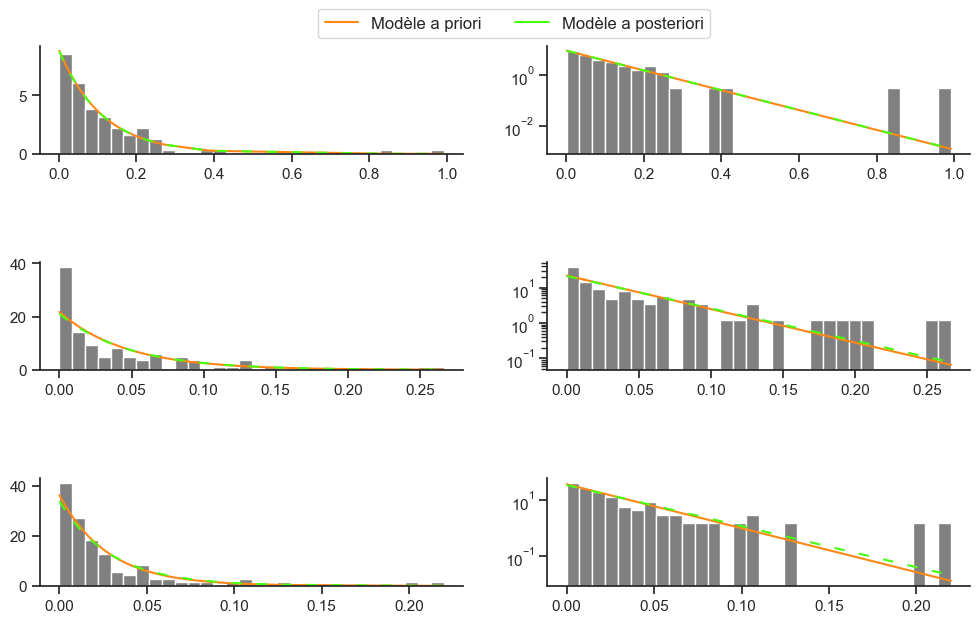

In [35]:
path = os.path.abspath("")
files_name = listNameOfFiles(path)

t0 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[0])))
t1 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[1])))
t2 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[2])))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,9))
for i in ax[:,1]:
    i.set_yscale("log")
plt.subplots_adjust(bottom=0.9, top=1.5, wspace=0.2, hspace=1)
for i in range(2):
    ax[0][i].hist(t0, bins=30, color="gray", density=True)
    ax[0][i].plot(t0, poisson(t0,1/np.mean(t0)), color="#FF8715", label="Modèle a priori")
    ax[0][i].plot(t0, poisson(t0,8.87962669324514), linestyle=(0, (5,7)), color="#47FF0F", label="Modèle a posteriori")
    
    ax[1][i].hist(t1, bins=30, color="gray",density=True)
    ax[1][i].plot(t1, poisson(t1,1/np.mean(t1)), color="#FF8715", label="Modèle a priori")
    ax[1][i].plot(t1, poisson(t1,21.07028444884007), linestyle=(0, (5,7)), color="#47FF0F", label="Modèle a posteriori")
    
    ax[2][i].hist(t2, bins=30, color="gray", density=True)
    ax[2][i].plot(t2, poisson(t2,1/np.mean(t2)), color="#FF8715", label="Modèle a priori")
    ax[2][i].plot(t2, poisson(t2,33.91355504031561), linestyle=(0, (5,7)), color="#47FF0F", label="Modèle a posteriori")

legend_elements = [Line2D([],[], color="#FF8715", label="Modèle a priori"), Line2D([],[], color="#47FF0F", label="Modèle a posteriori")]
fig.legend(handles=legend_elements, fontsize=12, loc=9, bbox_to_anchor=(0.27,1.05,0.5,0.5), ncols=2)
plt.show()

#### 8.

Avec vos connaissances sur le processus de Poisson et l’inférence bayésienne, que pouvez-vous
conclure du comportement de chaque neurone grâce à vos résultats ? Les processus sont-ils
poissonien dans tous les cas ? Vous pouvez soutenir votre réponse en utilisant le fait que
− log(f(x)) croît en fonction d’un modèle qui décrit de mieux en mieux les données.